In [2]:
import pymongo
import datetime
import matplotlib as plt
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from pymongo import MongoClient
from datetime import datetime

In [3]:
client = MongoClient('localhost', 27017)
db = client.db
comments = db.comments

commentdf = pd.DataFrame.from_records(comments.find({'created_utc': {'$exists': True}}))

In [4]:
commentdf['size'] = commentdf['stocks'].apply(lambda x: len(x))
commentdf = commentdf.loc[commentdf['size'] != 0]

s = commentdf['stocks']
mlb = MultiLabelBinarizer()
onehotdf = pd.DataFrame(mlb.fit_transform(s), columns = mlb.classes_, index = commentdf.index)

In [23]:
analyze = 'SPY'

spydf = commentdf.loc[onehotdf.loc[onehotdf[analyze] != 0].index]
stockdf = yf.download(analyze, start = '2019-10-01', end = '2020-10-03', progress = False)
dayBins = list(stockdf.reset_index()['Date'])
spydf['created_utc'] = [pd.Timestamp(datetime.utcfromtimestamp(time)) for time in spydf['created_utc']]
spydf['days'] = pd.cut(spydf['created_utc'], bins = dayBins, labels=stockdf.reset_index()['Date'][0:254])


spydf.reset_index(drop=True,inplace=True)
spydf['days'] = spydf['days'].astype('datetime64[ns]')
stockdf = stockdf.reset_index()

for i in range(len(stockdf['Open'])-1):
    orig = stockdf.loc[i, 'Open']
    new = stockdf.loc[i + 1, 'Open']
    change = (new-orig)/orig
    stockdf.at[i+1, 'Change'] = change*100
    stockdf.at[i, 'result'] = change*100
for i in range(len(stockdf['Open']) - 2):
    stockdf.at[i + 2, '3day'] = stockdf.loc[i, 'Change'] + stockdf.loc[i + 1, 'Change'] + stockdf.loc[i + 2, 'Change']
    if i < (len(stockdf['Open']) - 6):
        stockdf.at[i + 6, '7day'] = stockdf.loc[i, 'Change'] + stockdf.loc[i + 1, 'Change'] + stockdf.loc[i + 2, 'Change'] + stockdf.loc[i + 3, 'Change'] + stockdf.loc[i + 4, 'Change'] + stockdf.loc[i + 5, 'Change'] + stockdf.loc[i + 6, 'Change']

testdf = spydf
stockdf.dropna().reset_index(drop=True, inplace=True)
testdf = pd.merge(testdf, stockdf, left_on='days', right_on='Date')
testdf = testdf.dropna().drop(columns = ['id', 'stocks', 'days', 'Date', 'High', 'Low', 'Close', 'Adj Close'])
testdf.reset_index(drop=True, inplace=True)
testdf['Hour'] = testdf['created_utc'].apply(lambda x: x.hour)
testdf['length'] = testdf['body'].apply(lambda x: len(x.split()))
testdf.drop(columns = ['created_utc', 'body'], inplace=True)
testdf['Change'] = testdf['Change'].apply(lambda x: 1 if x > 0.2 else (-1 if x < -0.2 else 0))
testdf['3day'] = testdf['3day'].apply(lambda x: 1 if x > 0.6 else(-1 if x < -0.6 else 0))
testdf['7day'] = testdf['7day'].apply(lambda x: 1 if x > 1.4 else (-1 if x < -1.4 else 0))
testdf['result'] = testdf['result'].apply(lambda x: 1 if x > 0.2 else (-1 if x < -0.2 else 0))
testdf['sentiment'] = testdf['sentiment'].apply(lambda x: 1 if x == 'bullish' else(-1 if x == 'bearish' else 0))
#testdf = testdf.join(pd.get_dummies(testdf['sentiment'])).drop(columns=['sentiment'])

biasid = spydf.loc[spydf['days'].isin(stockdf['Date'].sample(n=25))]['_id']

biasdf = testdf.loc[testdf['_id'].isin(biasid)]
testdf = testdf.loc[~testdf['_id'].isin(biasid)]

labels = np.array(testdf['result'])
features = testdf.drop(columns = ['Open','result', 'Volume', '_id', 'length'])

feature_list = list(features.columns)
features = np.array(features)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

rf = RandomForestClassifier(n_estimators=100, max_depth=50)
rf.fit(train_features, train_labels)

predictions = rf.predict(test_features)

errors = 0
for i in range(len(predictions)):
    if predictions[i] != test_labels[i]:
        errors += 1


bias_labels = np.array(biasdf['result'])
bias_features = np.array(biasdf.drop(columns = ['Open', 'result', 'Volume', '_id', 'length']))

biaspred = rf.predict(bias_features)

biaserror = 0
for i in range(len(biaspred)):
    if biaspred[i] != bias_labels[i]:
        biaserror += 1

print(f1_score(predictions, test_labels, average=None))
print(f1_score(biaspred, bias_labels, average=None))
print(errors/len(test_labels))
print(biaserror/len(bias_labels))

[0.48680352 0.13098592 0.66812578]
[0.51990899 0.08298052 0.65429329]
0.42699172834131477
0.46520833333333333


Feature ranking:
1. feature 0 (0.346113)
2. feature 6 (0.211139)
3. feature 3 (0.128337)
4. feature 4 (0.123599)
5. feature 5 (0.115875)
6. feature 2 (0.058723)
7. feature 1 (0.016214)


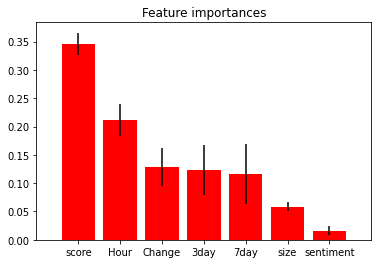

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier


# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(train_features, train_labels)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
xlabel = []
for i in indices:
    xlabel.append(feature_list[i])

# Print the feature ranking
print("Feature ranking:")

for f in range(train_features.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_features.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(train_features.shape[1]), xlabel)
plt.xlim([-1, train_features.shape[1]])
plt.savefig('plot.jpg')
plt.show()